In [1]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

In [18]:
# dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Get unique user IDs

        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size/(1-test_size), random_state=42)

    else:
        print('Wrong data input')
        return None, None, None

    # Print the sizes of the datasets
    print(f"Train set size: {train.shape[0]} ratings")
    print(f"Validation set size: {val.shape[0] if val is not None else 0} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    print(ml_full.shape[0])
    print(train.shape[0] + val.shape[0] +  test.shape[0])

    return train, val, test, n_users, n_items

def load_confounders(dat, k):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data

def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, val, test, n_users, n_items = choose_data(dat, test_size, val_size)

    if train is None or test is None:
        return None, None, None, None, None

    if include_validation:
        # Use the provided validation set
        vad = val
    else:
        # Merge train and validation sets if validation is not required, and sort by userId
        train = pd.concat([train, val]).sort_values(by='userId').reset_index(drop=True)
        vad = None

    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)
    vad_matrix = build_matrix(vad) if vad is not None else None

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, vad_matrix, n_users, n_items






random seed:  42


In [55]:
def run_model(module_name, class_name, k, dat='ml', include_validation=False, use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None):
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)

    confounder_data = None
    exposure_data = None

    if use_confounder:
        # Load confounder data
        confounder_data = load_confounders(dat, k)
    if use_exposure:
        # Create exposure matrix
        exposure_data = (train > 0).astype(np.float32).todense().T
    
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        # Dynamically import the module and create an instance of the chosen class
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        final_model.build_network(hidden_neuron=hidden_neuron)
        
        # Determine how many arguments to pass to the execute function
        if confounder_data is not None and exposure_data is not None:
            final_model.execute(train, test, confounder_data, exposure_data)
        elif confounder_data is not None:
            final_model.execute(train, test, confounder_data)
        else:
            final_model.execute(train, test)

        # Save the training and test RMSE values
        if save_path:
            class_folder = os.path.join(save_path, class_name.lower())
            os.makedirs(class_folder, exist_ok=True)

            train_loss_file = os.path.join(class_folder, f'train_loss_{dat}_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'test_rmse_{dat}_k{k}.npy')
            final_rmse_file = os.path.join(class_folder, f'final_rmse_{dat}_k{k}.npy')
            final_mae_file = os.path.join(class_folder, f'final_mae_{dat}_k{k}.npy')

            np.save(train_loss_file, np.array(final_model.train_loss_history))
            np.save(test_rmse_file, np.array(final_model.test_rmse_history))

            if confounder_data is not None and exposure_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data, exposure_data)
            elif confounder_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data)
            else:
                final_rmse, final_mae = final_model.test(test)

            np.save(final_rmse_file, np.array(final_rmse))
            np.save(final_mae_file, np.array(final_mae))

        print(f"Final RMSE: {final_rmse}, Final MAE: {final_mae}")


def run_all_models(result_path, models, k_values):
    for k in k_values:
        for model in models:
            use_confounder = 'conf' in model['module_name']
            use_exposure = 'exp' in model['module_name']
            
            print(f"Running {model['class_name']} with k={k}, use_confounder={use_confounder}, use_exposure={use_exposure}")
            run_model(model['module_name'], model['class_name'], k, dat='ml', include_validation=False, use_confounder=use_confounder, use_exposure=use_exposure, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=80, batch_size=500, verbose=True, save_path=result_path)
            print(f"Completed {model['class_name']} with k={k}")


In [59]:
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    # {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
k_values = [100]

run_all_models(result_path, models, k_values)


Running UAutoRec with k=32, use_confounder=False, use_exposure=False
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec.


Training: 100%|██████████| 80/80 [06:19<00:00,  4.75s/epoch, Loss=5.59e+4, RMSE=0.895, MAE=0.71] 


Final RMSE: 0.8951881399552926, Final MAE: 0.7104915246735076
Completed UAutoRec with k=32


uautorec (k=32) - Train loss history shape: (80,)
uautorec (k=32) - Test RMSE history shape: (80,)
uautorec1conf (k=32) - Train loss history shape: (80,)
uautorec1conf (k=32) - Test RMSE history shape: (80,)
uautorec1confexp (k=32) - Train loss history shape: (80,)
uautorec1confexp (k=32) - Test RMSE history shape: (80,)
uautorec2conf (k=32) - Train loss history shape: (80,)
uautorec2conf (k=32) - Test RMSE history shape: (80,)
uautorec2confexp (k=32) - Train loss history shape: (80,)
uautorec2confexp (k=32) - Test RMSE history shape: (80,)
uautorec3conf (k=32) - Train loss history shape: (80,)
uautorec3conf (k=32) - Test RMSE history shape: (80,)
uautorec3confexp (k=32) - Train loss history shape: (80,)
uautorec3confexp (k=32) - Test RMSE history shape: (80,)
uautorec4conf (k=32) - Train loss history shape: (80,)
uautorec4conf (k=32) - Test RMSE history shape: (80,)
uautorec4confexp (k=32) - Train loss history shape: (80,)
uautorec4confexp (k=32) - Test RMSE history shape: (80,)


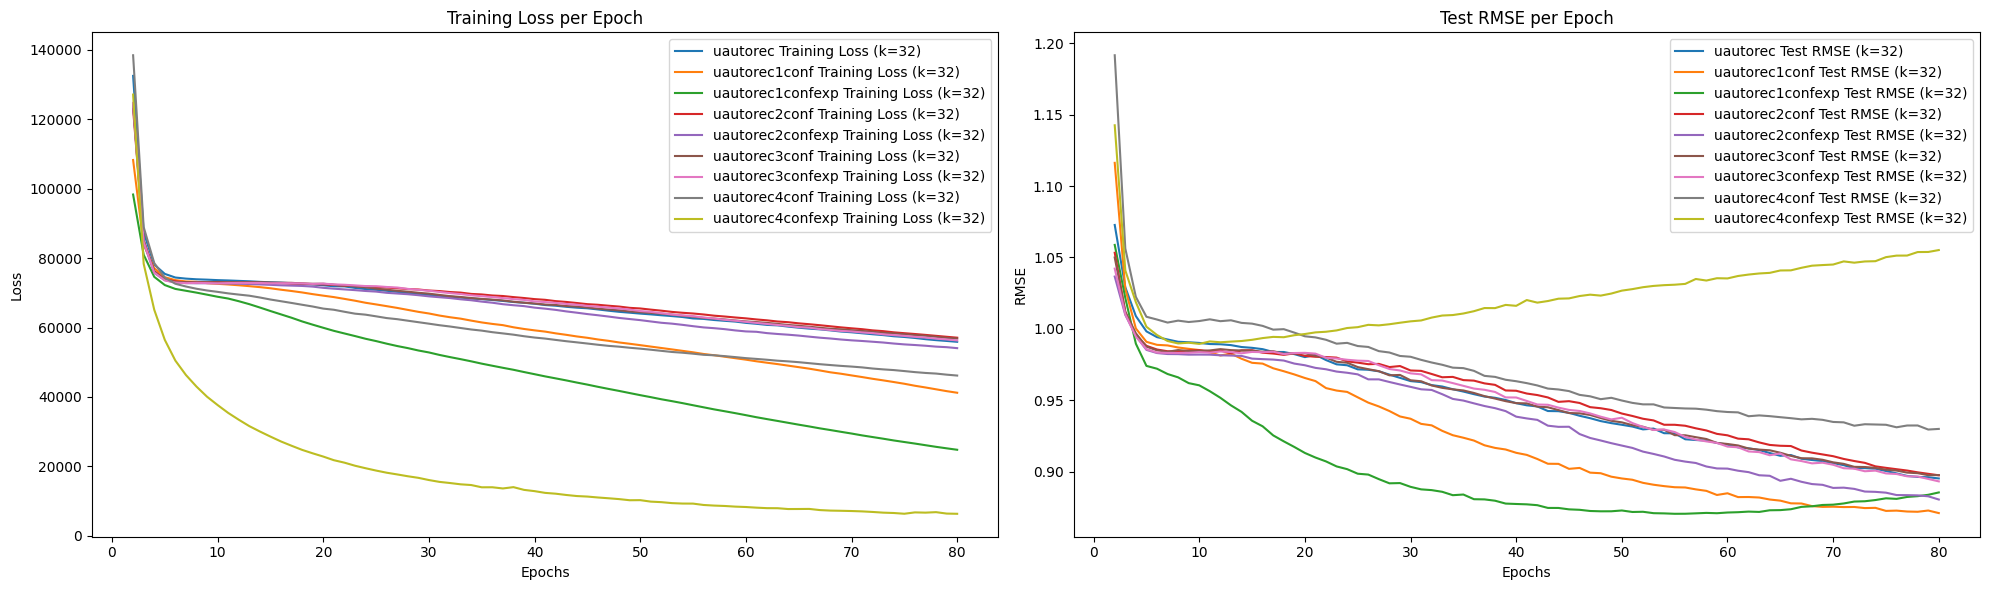

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_results(result_path, models, k_values):
    plt.figure(figsize=(20, 6))

    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            train_loss_file = os.path.join(class_folder, f'train_loss_ml_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'test_rmse_ml_k{k}.npy')

            if not os.path.exists(train_loss_file) or not os.path.exists(test_rmse_file):
                print(f"Files for {class_name} with k={k} not found.")
                continue

            train_loss_history = np.load(train_loss_file)
            test_rmse_history = np.load(test_rmse_file)

            print(f"{class_name} (k={k}) - Train loss history shape: {train_loss_history.shape}")
            print(f"{class_name} (k={k}) - Test RMSE history shape: {test_rmse_history.shape}")

            epochs = np.arange(1, len(train_loss_history) + 1)

            # Plot training loss
            plt.subplot(1, 2, 1)
            plt.plot(epochs[1:], train_loss_history[1:], label=f'{class_name} Training Loss (k={k})')
            
            # Plot test RMSE
            plt.subplot(1, 2, 2)
            plt.plot(epochs[1:], test_rmse_history[1:], label=f'{class_name} Test RMSE (k={k})')

    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Test RMSE per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1Conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1ConfExp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2Conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2ConfExp'},
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3Conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3ConfExp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4Conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4ConfExp'}
]
k_values = [32]  # Add all the k values you want to plot

plot_results(result_path, models, k_values)

In [ ]:
def run_model(module_name, class_name, k, dat='ml', include_validation=False, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=3, display_step=1000, save_path=None):
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)

    # Load confounder data
    confounder_data = load_confounders(dat, k)

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        # Dynamically import the module and create an instance of the chosen class
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        final_model.build_network(hidden_neuron=hidden_neuron)
        final_model.execute(train, test, confounder_data)

        # Save the training and test RMSE values
        if save_path:
            class_folder = os.path.join(save_path, class_name.lower())
            os.makedirs(class_folder, exist_ok=True)

            train_loss_file = os.path.join(class_folder, f'train_loss_{dat}_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'test_rmse_{dat}_k{k}.npy')

            np.save(train_loss_file, np.array(final_model.train_loss_history))
            np.save(test_rmse_file, np.array(final_model.test_rmse_history))

        # Evaluate the final model on the test set
        final_rmse, final_mae = final_model.test(test, confounder_data)
        print(f"Final RMSE: {final_rmse}, Final MAE: {final_mae}")

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
run_model('urec_2_conf', 'UAutoRec2conf', k=30, dat='ml', include_validation=False, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=500, verbose=True, save_path=result_path)